# Trace Event Heatmap

How to generate a FlameScope heatmap out of Google's Trace Event format, using Duration ('B' and 'E') and Complete ('X') events. This heatmap does not include the 'CpuProfile' Instant event profile. Example file was recorded in Chrome.

In [1]:
f = open('examples/Profile-20180724T170454_abcnews', 'r')

In [2]:
import json

data = json.load(f)

In [4]:
import math

COLUMN_DURATION = 1000000 # 1 sec

root_slices = []
events = {}
start_time = None
end_time = None

# TODO: handle CPU time differences, where "E" comes before "B"

for row in data:
    if row['ph'] != 'M':
        rounded_start_time = math.floor(row['ts'] / COLUMN_DURATION) * COLUMN_DURATION
        rounded_end_time = math.ceil(row['ts'] / COLUMN_DURATION) * COLUMN_DURATION
        if start_time is None or rounded_start_time < start_time:
            start_time = rounded_start_time
        if end_time is None or rounded_end_time > end_time:
            end_time = rounded_end_time
    key = str(row['pid']) + '_' + str(row['tid'])
    if row['ph'] == 'B' or row['ph'] == 'E':
        if row['ph'] == 'B':
            if key not in events:
                events[key] = { 'ts': row['ts'], 'tts': row['tts'], 'children_count': 0 }
            else:
                events[key]['children_count'] = events[key]['children_count'] + 1
        elif row['ph'] == 'E':
            if events[key]['children_count'] > 0:
                events[key]['children_count'] = events[key]['children_count'] - 1
            else:
                root_slices.append({'start': events[key]['ts'], 'cpu_start': events[key]['tts'], 'end': row['ts'], 'cpu_end': row['tts']})
                del events[key]
    elif row['ph'] == 'X':
        if 'dur' in row and row['dur'] > 0 and 'tdur' in row and row['tdur'] > 0:
            if key not in events: # it's a root event
                root_slices.append({'start': row['ts'], 'cpu_start': row['tts'], 'end': row['ts'] + row['dur'], 'cpu_end': row['tts'] + row['tdur']})

In [5]:
ROWS = 50 # 20 ms

interval = COLUMN_DURATION / ROWS
duration = end_time - start_time
columns = duration / interval / ROWS

heatmap = [[0 for i in range(ROWS)] for j in range(int(columns))]
usage_line = [0 for i in range(math.ceil(duration / interval))]

In [6]:
for s in root_slices:
    first_index = int((s['start'] - start_time) // interval)
    last_index = int((s['end'] - start_time) // interval)
    usage = (s['cpu_end'] - s['cpu_start']) / (s['end'] - s['start'])
    for i in range(first_index, last_index):
        usage_line[i] = usage_line[i] + usage
        if i > 0:
            col_index = int(i // ROWS)
            row_index = int(i % ROWS)
        else:
            col_index = 0
            row_index = 0
        heatmap[col_index][row_index] = heatmap[col_index][row_index] + usage

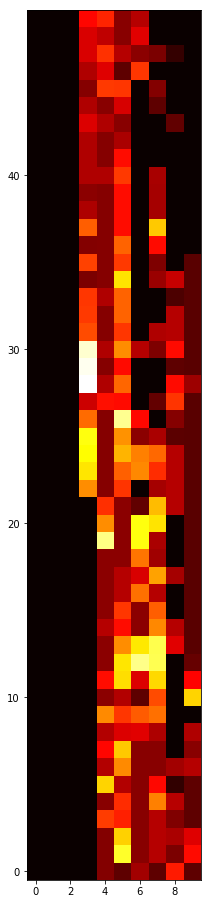

In [7]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [16, 16]

plt.imshow(np.transpose(heatmap), cmap='hot', origin='lower')
plt.show()

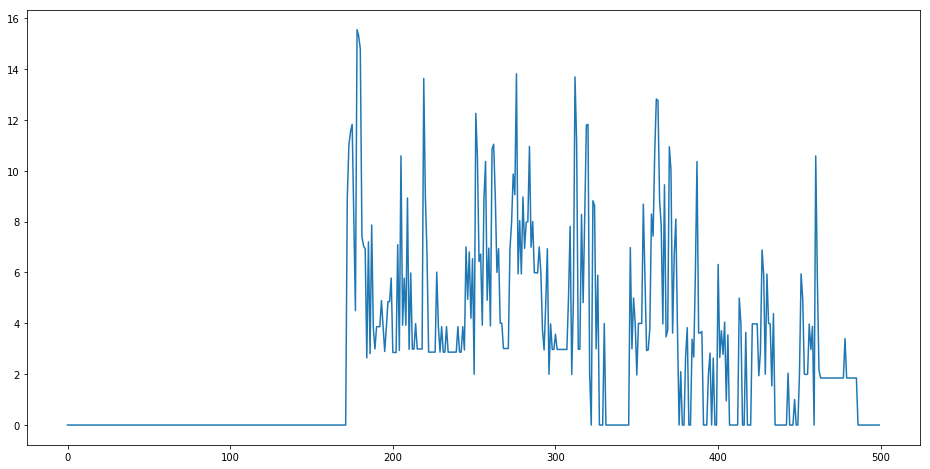

In [8]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [16, 8]
plt.plot(usage_line)
plt.show()